<a href="https://colab.research.google.com/github/JSRist0028/animalmigration/blob/main/code/Migration_Data_Prediction_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas
!pip install shapely
!pip install meteostat 

     |████████████████████████████████| 1.0MB 9.4MB/s 
     |████████████████████████████████| 6.5MB 29.9MB/s 
     |████████████████████████████████| 15.3MB 246kB/s 
  Created wheel for meteostat: filename=meteostat-1.2.2-cp37-none-any.whl size=15689 sha256=5a536d42dcadc5fb0f43d34daa1f90fc4a59c4adb4572bafdeddf9db0db84e55
  Stored in directory: /root/.cache/pip/wheels/bd/22/d0/1f8b9bdc0d26b89e0132a4e9d445f793a3ee13716485029415
Successfully built meteostat


In [2]:
import pandas as pd
import sklearn.preprocessing
import sklearn.manifold 
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
from datetime import datetime
import meteostat
from meteostat import Stations, Daily
from dateutil.relativedelta import relativedelta
import datetime as dt
from datetime import datetime

**Change the csv file and whether or not to include temperature here:**

In [3]:
# import data with combined temperature and tracking information

data_raw = pd.read_csv('https://github.com/JSRist0028/animalmigration/blob/0175410b123d51c6463a7d5e1130bdf68373d68c/data/barnacle_geese_data_matrix?raw=true')

# geese data: ('https://github.com/JSRist0028/animalmigration/blob/main/data/barnacle_geese_data_matrix?raw=true')
# whale data: ('https://raw.githubusercontent.com/JSRist0028/animalmigration/main/data/Azores%20Great%20Whales%20Satellite%20Telemetry%20Program%20.csv')


includeTemp =True
data_raw

,row number,timestamp,latitude,longitude,height,speed,heading,birdID,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_lat,station_long
0,0,2009-02-11 10:00:00,53.40483,6.15600,1.0,0.0,98.0,78033,11.2,3.9,20.0,0.0,0.0,NaN,6.1,NaN,1022.6,NaN,33.5667,-86.75
1,1,2009-02-12 10:00:00,53.36217,6.13750,1.0,0.0,61.0,78033,11.3,2.8,18.3,0.3,0.0,NaN,6.5,NaN,1020.2,NaN,33.5667,-86.75
2,2,2009-02-13 10:00:00,53.34833,6.12833,1.0,0.0,3.0,78033,12.6,7.2,18.3,0.5,0.0,NaN,8.3,NaN,1015.4,NaN,33.5667,-86.75
3,3,2009-02-14 10:00:00,53.34617,6.11950,1.0,0.0,329.0,78033,9.0,2.8,16.1,0.0,0.0,NaN,11.9,NaN,1019.7,NaN,33.5667,-86.75
4,4,2009-02-15 07:00:00,53.34633,6.15650,1.0,1.0,243.0,78033,4.8,-0.6,12.2,0.0,0.0,NaN,10.1,NaN,1026.6,NaN,33.5667,-86.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5940,5940,2009-06-18 06:00:00,60.31100,27.08567,1.0,0.0,156.0,78042b,28.8,22.2,34.4,0.0,0.0,NaN,6.1,NaN,1013.9,NaN,33.5667,-86.75
5941,5941,2009-06-19 09:00:00,60.31100,27.08567,1.0,0.0,25.0,78042b,29.1,22.8,34.4,0.0,0.0,NaN,7.9,NaN,1013.4,NaN,33.5667,-86.75
5942,5942,2009-06-20 06:00:00,60.31100,27.08567,0.0,0.0,295.0,78042b,29.2,23.9,34.4,0.0,0.0,NaN,7.9,NaN,1012.3,NaN,33.5667,-86.75
5943,5943,2009-06-21 06:00:00,60.31100,27.08567,1.0,0.0,333.0,78042b,29.5,23.9,34.4,0.0,0.0,NaN,9.4,NaN,1010.3,NaN,33.5667,-86.75


In [4]:
# creates dataframe with only unique dates

def date_to_nth_day(date):#, format='%Y%m%d'):
    date = pd.to_datetime(date)#, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
# source: https://codereview.stackexchange.com/questions/154140/interpret-yyyymmdd-as-the-nth-day-of-the-year


# create a new DataFrame with only location data from unique days
# this is now redundant
data = pd.DataFrame(columns=data_raw.columns) # create header
for i, row in data_raw.iterrows():
  if i>0: # skip first row
    if (date_to_nth_day(row['timestamp']) != date_to_nth_day(data_raw['timestamp'][i-1])): 
      data = data.append(row, ignore_index=True)
      #print(i)

In [5]:
# Splits data into features (today) and targets (tomorrow)
def get_todaytomorrow(data, includeTemp):
  num_rows = len(data)
  today_timestamp = np.empty((0,1))
  tomorrow_timestamp = np.empty((0,1))
  if includeTemp:
    today = np.empty((0,7), dtype='float')#, 'int') #[]
  else:
    today = np.empty((0,4), 'int') #[]
  tomorrow = np.empty((0,3), dtype='float') #, 'int') #[]
  for i, row in data.iterrows():
    if (i<(num_rows-3)):
      if (pd.notnull(row['tavg']) & pd.notnull(data['tavg'][i+1])): # only add pair if both contain basic weather data (avg temp)
        if (data['birdID'][i]==data['birdID'][i+1]):                # only add if birdIDs match
          today_day = date_to_nth_day(row['timestamp'])
          tomorrow_day = date_to_nth_day(data['timestamp'][i+1])
#          if (tomorrow_day-today_day == 1):                         # makes sure that the days are consecutive -> already done ^
          birdID_today = row['birdID'].replace('a','1')
          birdID_today = birdID_today.replace('b', '2')
          birdID_tomorrow = data['birdID'][i+1].replace('a','1')
          birdID_tomorrow = birdID_tomorrow.replace('b','2')
          today_timestamp = np.append(today_timestamp, row['timestamp'])
          tomorrow_timestamp = np.append(tomorrow_timestamp, data['timestamp'][i+1])
          if includeTemp:
            today_entry = np.asarray([int(birdID_today), today_day, row['latitude'], row['longitude'], row['tavg'], row['tmin'], row['tmax'] ])
            tomorrow_entry = np.asarray([int(birdID_tomorrow), data['latitude'][i+1], data['longitude'][i+1]]) #no change
          else:
            today_entry = np.asarray([int(birdID_today), today_day, row['latitude'], row['longitude']])
            tomorrow_entry = np.asarray([int(birdID_tomorrow), data['latitude'][i+1], data['longitude'][i+1]]) # no change
          today_entry[np.isnan(today_entry)]=0
          tomorrow_entry[np.isnan(tomorrow_entry)]=0
          today = np.vstack((today,today_entry))
          tomorrow = np.vstack((tomorrow, tomorrow_entry))
         #print(i)
  return today, tomorrow, today_timestamp, tomorrow_timestamp

today, tomorrow, today_timestamp, tomorrow_timestamp = get_todaytomorrow(data, includeTemp=includeTemp)

In [6]:
# Split the data into training and testing sets
features = today[:,1:] #data.values[:,:-1]
labels = tomorrow[:,1:] #[:,[1,2]] #data.values[:, 60]
#features = features.reshape(features.shape[0], features.shape[1], 1) if using CNN, may need to use this
import math
# Split the data into training and testing sets cronologically

todaydf = pd.DataFrame(today)
tomorrowdf = pd.DataFrame(tomorrow)

def train_test_split(datafile, tomorrow, train_ratio, includeTemp):
    
    # Define dataframes to return
    if includeTemp:
      xheaders = ['AnimalID', 'TS', 'Lat - 1', 'Long - 1', 'TAvg', 'TMin', 'TMax']
    else:
      xheaders = ['AnimalID', 'TS', 'Lat - 1', 'Long - 1']
    yheaders = ['AnimalID', 'Lat', 'Long']
    
    trainx = pd.DataFrame(columns = xheaders)
    trainy = pd.DataFrame(columns = yheaders)
    testx = pd.DataFrame(columns = xheaders)
    testy = pd.DataFrame(columns = yheaders)
    
    # Split each unique animal tracking info into training and testing sets
    
    for animal in datafile[0].unique():
        traincount = math.ceil(float(datafile[datafile[0] == animal].shape[0]) * train_ratio)
        obscount = datafile[datafile[0] == animal].shape[0]
        obslist = datafile.index[datafile[0] == animal].tolist()
        
        for obs in range(0, traincount, 1):
            if includeTemp:
              dfx = [animal, datafile[1][obslist[obs]], datafile[2][obslist[obs]], datafile[3][obslist[obs]],
                   datafile[4][obslist[obs]], datafile[5][obslist[obs]], datafile[6][obslist[obs]]]
            else:
              dfx = [animal, datafile[1][obslist[obs]], datafile[2][obslist[obs]], datafile[3][obslist[obs]]]
            dfy = [animal, tomorrow[1][obslist[obs]], tomorrow[2][obslist[obs]]]
            
            trainx.loc[len(trainx.index)] = dfx
            trainy.loc[len(trainy.index)] = dfy

        for obs in range(traincount, obscount, 1):
            if includeTemp:
              dfx = [animal, datafile[1][obslist[obs]], datafile[2][obslist[obs]], datafile[3][obslist[obs]],
                   datafile[4][obslist[obs]], datafile[5][obslist[obs]], datafile[6][obslist[obs]]]
            else:
              dfx = [animal, datafile[1][obslist[obs]], datafile[2][obslist[obs]], datafile[3][obslist[obs]]]
            dfy = [animal, tomorrow[1][obslist[obs]], tomorrow[2][obslist[obs]]]
            
            testx.loc[len(testx.index)] = dfx
            testy.loc[len(testy.index)] = dfy
    
    return(trainx, trainy, testx, testy)

trainin_x, trainin_y, testin_x, testin_y = train_test_split(todaydf, tomorrowdf, 0.8,includeTemp)



In [40]:
trainin_x

,AnimalID,TS,Lat - 1,Long - 1,TAvg,TMin,TMax
0,78033.0,43.0,53.36217,6.13750,11.3,2.8,18.3
1,78033.0,44.0,53.34833,6.12833,12.6,7.2,18.3
2,78033.0,45.0,53.34617,6.11950,9.0,2.8,16.1
3,78033.0,46.0,53.34633,6.15650,4.8,-0.6,12.2
4,78033.0,47.0,53.33800,6.14467,5.4,-1.1,10.0
...,...,...,...,...,...,...,...
4659,780422.0,142.0,60.31150,27.08467,21.4,20.0,22.8
4660,780422.0,143.0,60.31183,27.08450,23.4,20.6,28.3
4661,780422.0,144.0,60.31167,27.08433,22.0,19.4,27.8
4662,780422.0,145.0,60.31167,27.08433,22.0,20.6,25.6


In [43]:
# converts data into correct type for keras model
if includeTemp:
  training_x = np.transpose(np.asarray([trainin_x['TS'], trainin_x['Lat - 1'], trainin_x['Long - 1'], trainin_x['TAvg'], trainin_x['TMin'], trainin_x['TMax']]).astype('float32'))
  testing_x = np.transpose(np.asarray([testin_x['TS'], testin_x['Lat - 1'], testin_x['Long - 1'], testin_x['TAvg'], testin_x['TMin'], testin_x['TMax']]).astype('float32'))
else:
  training_x = np.transpose(np.asarray([trainin_x['TS'], trainin_x['Lat - 1'], trainin_x['Long - 1']]).astype('float32'))
  testing_x = np.transpose(np.asarray([testin_x['TS'], testin_x['Lat - 1'], testin_x['Long - 1']]).astype('float32'))
training_y = np.transpose(np.asarray([trainin_y['Lat'], trainin_y['Long']]).astype('float32'))
testing_y = np.transpose(np.asarray([testin_y['Lat'], testin_y['Long']]).astype('float32'))
# from https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape

# Regression Model 

In [45]:
# Regression packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers.experimental import preprocessing

In [46]:
# Normalization 
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(training_x))

In [48]:
from tensorflow import optimizers
best_eval = 10000 # big number
for i  in  range(1,10) :
  # Build model, add layers
  input_size = training_x.shape[1]
  my_model = Sequential([normalizer, Dense(units=1)])
  my_model.add(Dense(32, input_dim=input_size, kernel_initializer='normal', activation='relu'))
  #my_model.add(Conv1D(32, 3, activation="relu"))
  # my_model.add(Dense(16,  kernel_initializer='normal', activation='relu'))
  #my_model.add(Dense(16,  kernel_initializer='normal', activation='relu'))
  my_model.add(Dense(8,  kernel_initializer='normal', activation='relu'))
  my_model.add(Dense(2, kernel_initializer='normal'))
  
  # Train model
  my_model.compile(optimizer=optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')
  history = my_model.fit(training_x, training_y,epochs=50,verbose=0,validation_split = 0.2)

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist.tail()

  this_eval = my_model.evaluate(testing_x,testing_y, verbose=0) # hist.loss[49]
  print(this_eval) 
  if (this_eval< best_eval):
    print('this eval is better than best eval')
    best_eval = this_eval
    best_model = my_model
    best_history = history

0.7988438010215759
this eval is better than best eval
0.7378904223442078
this eval is better than best eval
1.3142786026000977
1.9094005823135376
0.8327822089195251
0.6744292974472046
this eval is better than best eval
0.9791008234024048
0.8661116361618042
0.7898377180099487


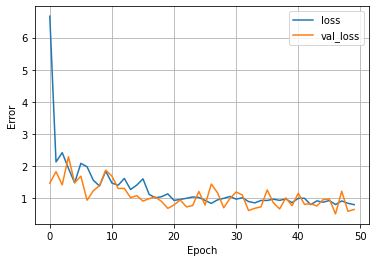

In [49]:
# Plot loss by Epoch to evaluate model improvement

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(best_history)

In [50]:
best_model.evaluate(testing_x,testing_y, verbose=0)

0.6744292974472046

In [51]:
best_model.evaluate(training_x,training_y, verbose=0)

0.6746488809585571

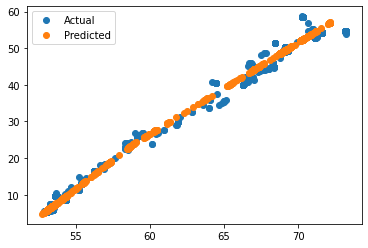

In [52]:
# Make predictions 

train_predictions = best_model.predict(training_x)#.flatten()
test_predictions = best_model.predict(testing_x)#.flatten()

test_predictions
fig,ax = plt.subplots()

ax.plot(testing_y[:,0], testing_y[:,1], 'o', label='Actual')
ax.plot(test_predictions[:,0], test_predictions[:,1], 'o', label='Predicted')
ax.legend()

Mean testing error: 1.0684633255004883
Mean training error: 1.0650488138198853


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


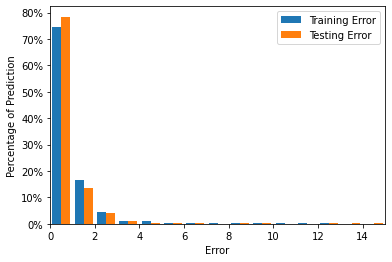

In [53]:
testing_error = np.sqrt((test_predictions[:,0] - testing_y[:,0])**2 + (test_predictions[:,1] - testing_y[:,1])**2)
training_error = np.sqrt((train_predictions[:,0] - training_y[:,0])**2 + (train_predictions[:,1] - training_y[:,1])**2)
# need to change this to account for lat/long to get real distance between points

print(f'Mean testing error: {np.mean(testing_error)}')
print(f'Mean training error: {np.mean(training_error)}')

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.scatter3D(training_y[:,0],training_y[:,1], training_error, label='Training Error', marker='x', depthshade=False)
#ax.scatter3D(testing_y[:,0],testing_y[:,1], testing_error,label='Testing Error', marker='x',depthshade=False)
#ax.legend()

from matplotlib.ticker import PercentFormatter
bins_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
fig = plt.figure()
plt.hist([training_error, testing_error], bins=bins_list, label=['Training Error', 'Testing Error'], weights=[np.ones(len(training_error))/len(training_error), np.ones(len(testing_error))/len(testing_error)])
#plt.hist(training_error, weights=np.ones(len(training_error))/len(training_error), label='Training Error', bins=bins_list )
#plt.hist(testing_error, weights=np.ones(len(testing_error))/len(testing_error), label='Testing Error',bins=bins_list)

plt.xlabel('Error')
plt.ylabel('Percentage of Prediction')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(0,15)
plt.legend()

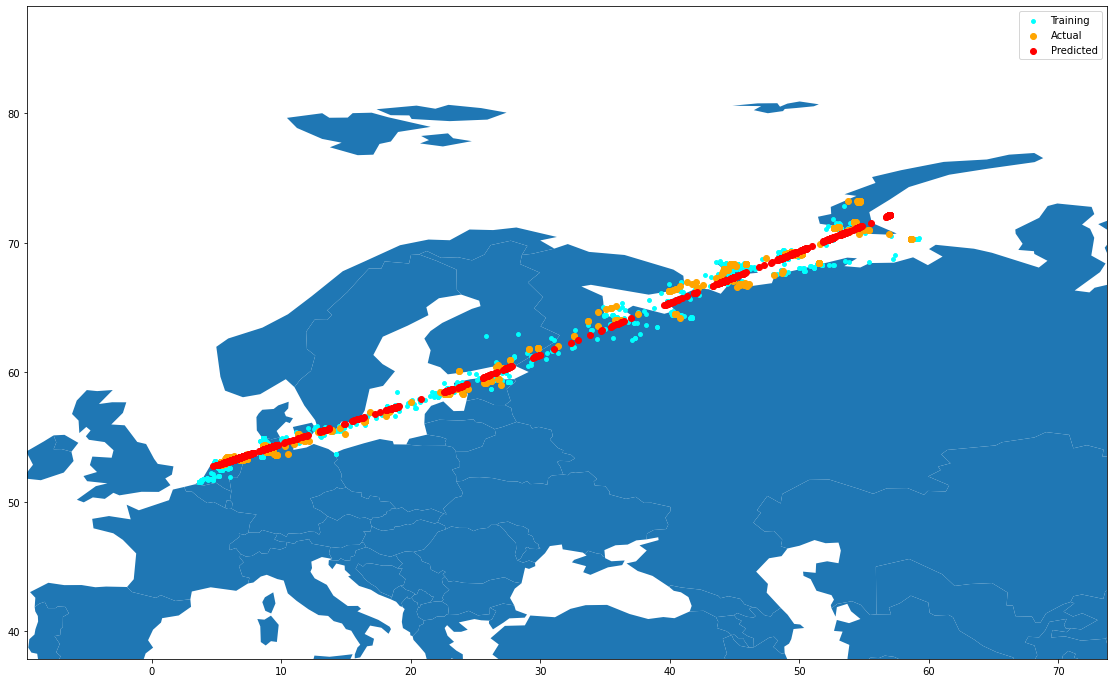

In [54]:
# Plot prediction on map 

from shapely.geometry import Point, LineString, MultiPoint
import geopandas as gpd
from geopandas import GeoDataFrame

actual_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(testing_y, axis=1))]],columns=['geometry'])
predicted_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(test_predictions, axis=1))]],columns=['geometry'])
training_plot = gpd.GeoDataFrame([[MultiPoint(np.flip(training_y, axis=1))]], columns=['geometry'])
minx, miny, maxx, maxy = actual_plot.geometry.total_bounds
 
fig, ax = plt.subplots(figsize=(20,12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax)
training_plot.plot(ax=ax,marker='o',label='Training', color='cyan', markersize=15)
actual_plot.plot(ax=ax, marker='o', label='Actual', color='orange')
predicted_plot.plot(ax=ax,marker='o',label='Predicted', color='red')

ax.set_xlim(minx - 15, maxx + 15) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 15, maxy + 15)
ax.legend()
#https://gis.stackexchange.com/questions/332624/geopandas-plot-two-layers-but-only-to-the-extent-of-the-smaller-one

# Predicting consecutive days of migration

In [55]:
def getWeather(stations, lat, long, mig_datetime):
   #stations = Stations()
   stations = stations.nearby(lat = 33.52068, lon = -86.81176,radius=40000) #note: radius is in meters (40k meters ~ 25 miles)
   station = stations.fetch(1)
   weather_data = Daily(station, start=mig_datetime,end=(mig_datetime+relativedelta(days=0)))
   weather_data = weather_data.fetch()
   
   weather_data_temp = weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']].values.tolist()
   if (not weather_data_temp): # sometimes it just creates an empty list. This checks/fixes it 
     weather_data_temp = np.empty((1,10), dtype='float')
     weather_data_temp[:] = np.NaN
   for i in range(2, stations.count()-1):
     if (np.isnan(weather_data_temp).any):
      station = stations.fetch(i)
      weather_data = Daily(station, start=mig_datetime,end=(mig_datetime + relativedelta(days=1)))
      weather_data = weather_data.fetch()

      #a = weather_data['wdir'].values[0].tolist()
      #print(a)
      try:

        if np.isnan(weather_data_temp[0][0]): #tavg
          [weather_data_temp[0][0]] = weather_data['tavg'].values.tolist()
        if np.isnan(weather_data_temp[0][1]): #tmin tmax
          [weather_data_temp[0][1]] = weather_data['tmin'].values.tolist()
          [weather_data_temp[0][2]] = weather_data['tmax'].values.tolist()
        if np.isnan(weather_data_temp[0][3]): #prcp
          [weather_data_temp[0][3]] = weather_data['prcp'].values.tolist()
        if np.isnan(weather_data_temp[0][4]): #snow
          [weather_data_temp[0][4]] = weather_data['snow'].values.tolist()
        if np.isnan(weather_data_temp[0][5]): #wdir
          [weather_data_temp[0][5]] = weather_data['wdir'].values.tolist()
        if np.isnan(weather_data_temp[0][6]): #wspd
          [weather_data_temp[0][6]] = weather_data['wspd'].values.tolist()
        if np.isnan(weather_data_temp[0][7]): #wpgt
          [weather_data_temp[0][7]] = weather_data['wpgt'].values.tolist()
        if np.isnan(weather_data_temp[0][8]): #pres
          [weather_data_temp[0][8]] = weather_data['pres'].values.tolist()
        if np.isnan(weather_data_temp[0][9]): #tsun
          [weather_data_temp[0][9]] = weather_data['tsun'].values.tolist()
      except:
        print("exception: ", weather_data)
   station_data = station.values[0]
   return weather_data_temp

In [56]:
#getWeather(stations, longtest_x[rows-1][0], longtest_x[rows-1][1], dt.datetime.strptime(tomorrow_timestamp[:][rows-1], "%Y-%m-%d %H:%M:%S"))
#getWeather(stations, longtest_x[rows][0], longtest_x[rows][1], dt.datetime.strptime(tomorrow_timestamp[:][rows], "%Y-%m-%d %H:%M:%S"))


In [57]:
 from dateutil.relativedelta import relativedelta

longtest_x = testing_x
longtest_y = best_model.predict([longtest_x[:][0].tolist()])

for rows in range(1, len(testin_x), 1):
  if includeTemp:
    stations = Stations()
    weather_data = getWeather(stations, longtest_x[rows][0], longtest_x[rows][1], dt.datetime.strptime(tomorrow_timestamp[:][rows], "%Y-%m-%d %H:%M:%S"))
    longtest_x_row = [longtest_x[:][rows].tolist()]
  else:
    longtest_x_row = [longtest_x[:][rows].tolist()]

  predict = best_model.predict(longtest_x_row)
  longtest_y = np.vstack((longtest_y, predict))

  if len(testin_x) > rows + 1:
    if testin_x['AnimalID'][rows] == testin_x['AnimalID'][rows + 1]:
      longtest_x[rows + 1, 1] = predict[0][0]
      longtest_x[rows + 1, 2] = predict[0][1]


exception:                      tavg  tmin  tmax  prcp  ...  wspd  wpgt    pres  tsun
station time                                ...                          
72228   2010-02-11   1.3  -3.9   6.1   0.0  ...  10.1   NaN  1020.5   NaN
        2010-02-12   0.3  -4.4   2.2   4.3  ...  10.8   NaN     NaN   NaN

[2 rows x 10 columns]


In [58]:
best_model.evaluate(testing_x, testing_y, verbose=0)

8.209689140319824

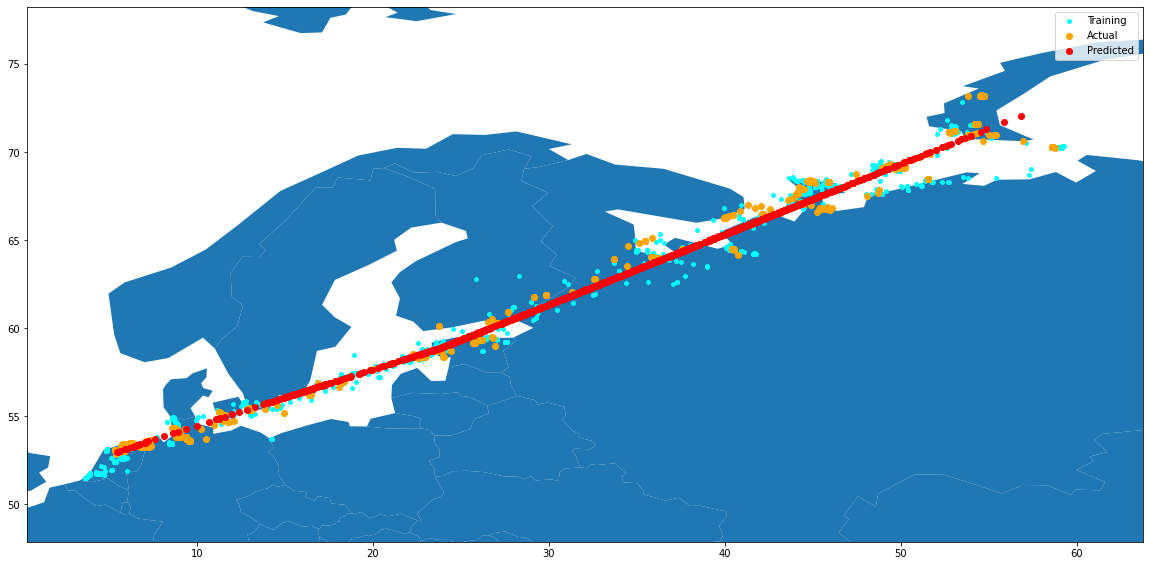

In [59]:
# Plot updated prediction on map 
actual_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(testing_y, axis=1))]],columns=['geometry'])
predicted_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(longtest_y, axis=1))]],columns=['geometry'])
training_plot = gpd.GeoDataFrame([[MultiPoint(np.flip(training_y, axis=1))]], columns=['geometry'])
minx, miny, maxx, maxy = actual_plot.geometry.total_bounds

fig, ax = plt.subplots(figsize=(20,12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax)
training_plot.plot(ax=ax,marker='o',label='Training', color='cyan', markersize=15)
actual_plot.plot(ax=ax, marker='o', label='Actual', color='orange')
predicted_plot.plot(ax=ax,marker='o',label='Predicted', color='red')

ax.set_xlim(minx - 5, maxx + 5) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 5, maxy + 5)
ax.legend()
#https://gis.stackexchange.com/questions/332624/geopandas-plot-two-layers-but-only-to-the-extent-of-the-smaller-one

In [60]:

np.savetxt("longtest_y_temp_geese.csv", longtest_y, delimiter=",")
np.savetxt("testing_y_temp_geese.csv", testing_y,  delimiter=",")


# Test model if global warming causes 2 degree warming


In [61]:
testing_x

,AnimalID,TS,Lat - 1,Long - 1,TAvg,TMin,TMax
0,78033.0,242.0,67.99500,44.24433,24.7,20.6,29.4
1,78033.0,243.0,67.99183,44.23433,25.9,18.9,32.8
2,78033.0,244.0,67.99267,44.23067,27.0,20.0,34.4
3,78033.0,245.0,67.99233,44.23683,26.9,20.6,33.3
4,78033.0,246.0,68.00567,44.20983,22.3,14.4,28.3
...,...,...,...,...,...,...,...
1151,780422.0,163.0,60.31167,27.08450,22.0,18.9,26.7
1152,780422.0,164.0,60.31167,27.08450,23.7,19.4,27.2
1153,780422.0,167.0,60.31150,27.08450,28.5,22.8,33.9
1154,780422.0,169.0,60.31100,27.08567,28.8,22.2,34.4


12.184312


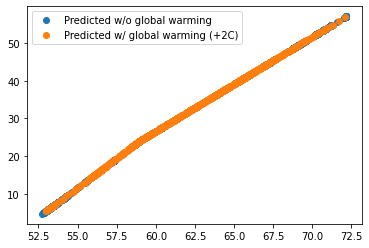

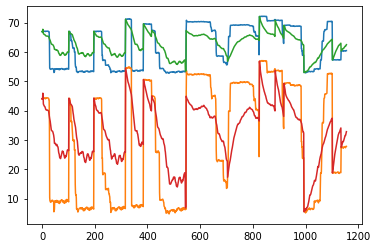

In [62]:
if includeTemp: 
  testing_x_gw = testing_x
  testing_x_gw[:][3:5] = testing_x[:][3:5]+2
  test_predictions_gw = best_model.predict(testing_x)#.flatten()

  fig,ax = plt.subplots()

  ax.plot(test_predictions[:,0], test_predictions[:,1], 'o', label='Predicted w/o global warming')
  ax.plot(test_predictions_gw[:,0], test_predictions_gw[:,1], 'o', label='Predicted w/ global warming (+2C)')
  ax.legend()

  change_with_gw = np.sqrt((test_predictions[:,0] - test_predictions_gw[:,0])**2 + (test_predictions[:,1] - test_predictions_gw[:,1])**2)
  print(np.mean(change_with_gw))
  
  fig,ax1 = plt.subplots()

  ax1.plot(test_predictions[:,0])
  ax1.plot(test_predictions[:,1])
  ax1.plot(test_predictions_gw[:,0])
  ax1.plot(test_predictions_gw[:,1])
  #ax1.plot(test_predictions_gw[:,0], test_predictions_gw[:,1], 'o', label='Predicted w/ global warming (+2C)')
  #ax1.legend()